# Lectura y Análisis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Disable tf warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras_tuner as kt
from keras import backend as K
import gc # garbage collector

2025-04-10 17:01:13.346274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744300873.365450  129204 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744300873.371471  129204 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Avoid memory issues with TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## Carga de datos

In [3]:
file_name = "grafcan_cuesta_features.csv"
dataset_path = "../1_tratamiento_datos/processed_data/" + file_name

df = pd.read_csv(dataset_path, parse_dates=['time']).drop(columns=['artificial_value_flag', 'outlier_flag'])

In [4]:
# Test/Train split #
####################
target_day = '2025-01-01'

indices = df[df['time'].dt.date == pd.to_datetime(target_day).date()].index
first_2025_index = indices[0]
print(df.iloc[first_2025_index])

time                    2025-01-01 00:00:00+00:00
air_temperature                         13.296237
atmospheric_pressure                   983.553589
relative_humidity                        83.11875
sin_day                                       0.0
cos_day                                       1.0
sin_year                                      0.0
cos_year                                      1.0
Name: 16128, dtype: object


In [5]:
###################################################
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return [(data - data_mean) / data_std, data_mean, data_std]
#################################################

no_normalize = ["sin_day", "cos_day", "sin_year", "cos_year"]

features = df.drop(columns=["time", *no_normalize]).astype("float32")

features.index = df["time"]

normalized_features, mean, std = normalize(features.values, first_2025_index)
normalized_features = pd.DataFrame(normalized_features, columns=features.columns)

for col in no_normalize:
    normalized_features[col] = df[col].astype("float32")

print(normalized_features.dtypes, normalized_features.head())

train_data = normalized_features.loc[0 : first_2025_index].reset_index(drop=True)
val_data = normalized_features.loc[first_2025_index:].reset_index(drop=True)

print(train_data.head())
print(val_data.head())

air_temperature         float32
atmospheric_pressure    float32
relative_humidity       float32
sin_day                 float32
cos_day                 float32
sin_year                float32
cos_year                float32
dtype: object    air_temperature  atmospheric_pressure  relative_humidity   sin_day  \
0        -1.018304              1.333987           0.670254  0.000000   
1        -1.062528              1.216466           0.716861  0.258819   
2        -1.149606              1.090952           1.053583  0.500000   
3        -1.249924              0.887425           1.078569  0.707107   
4        -1.374478              0.768502           1.157604  0.866025   

    cos_day  sin_year  cos_year  
0  1.000000  0.849817  0.527078  
1  0.965926  0.850195  0.526468  
2  0.866025  0.850572  0.525858  
3  0.707107  0.850949  0.525248  
4  0.500000  0.851326  0.524637  
   air_temperature  atmospheric_pressure  relative_humidity   sin_day  \
0        -1.018304              1.333987      

In [6]:
print("mean", mean)
print("std", std)

mean [ 20.345667 977.2128    68.56473 ]
std [ 3.4997928  3.3524375 16.775301 ]


In [7]:
# Training data structure #
###########################
past = 30
HOURS_TO_FORECAST = 3
future = HOURS_TO_FORECAST
STEP = 1

def create_dataset(target, features, past=1, future=1, step=1):
  label_start = past
  label_end = label_start + first_2025_index
  
  y_train_full = normalized_features.iloc[label_start:label_end][target]

  x_train = []
  future_train = []
  y_train_multi = []
  for i in range(0, len(train_data) - past - future + 1, step):
    x_window = train_data.iloc[i:i + past][features].values
    x_train.append(x_window)
    future_window = normalized_features.iloc[label_start + i:label_start + i + future][features].drop(columns=[target]).values
    future_train.append(future_window)
    y_window = y_train_full.iloc[i:i + future].values
    y_train_multi.append(y_window)
  x_train = np.array(x_train)
  future_train = np.array(future_train)
  y_train_multi = np.array(y_train_multi)

  # Validation data structure #
  #############################
  val_label_start = first_2025_index + past

  x_val = []
  future_val = []
  y_val_multi = []
  for i in range(0, len(val_data) - past - future + 1, step):
    x_window = val_data.iloc[i:i + past][features].values
    x_val.append(x_window)
    future_window = normalized_features.iloc[val_label_start + i:val_label_start + i + future][features].drop(columns=[target]).values
    future_val.append(future_window)
    y_window = normalized_features.iloc[val_label_start + i: val_label_start + i + future][target].values
    y_val_multi.append(y_window)
  x_val = np.array(x_val)
  future_val = np.array(future_val)
  y_val_multi = np.array(y_val_multi)
  
  return x_train, future_train, y_train_multi, x_val, future_val, y_val_multi

sets = {}


for target in ["air_temperature", "relative_humidity", "atmospheric_pressure"]:
  features = ["sin_day", "cos_day", "sin_year", "cos_year", target]
  x_train, future_train, y_train_multi, x_val, future_val, y_val_multi = create_dataset(target, features, past, future, STEP)
  sets[target] = {
    "x_train": x_train,
    "future_train": future_train,
    "y_train": y_train_multi,
    "x_val": x_val,
    "future_val": future_val,
    "y_val": y_val_multi
  }


KeyboardInterrupt: 

In [ ]:
x_train = sets["air_temperature"]["x_train"]
future_train = sets["air_temperature"]["future_train"]
y_train = sets["air_temperature"]["y_train"]

x_val = sets["air_temperature"]["x_val"]
future_val = sets["air_temperature"]["future_val"]
y_val = sets["air_temperature"]["y_val"]

#############
# BATCH AND SHUFFLE
#############
BATCH_SIZE = 64
SHUFFLE = False

dataset_train = tf.data.Dataset.from_tensor_slices(((x_train, future_train), y_train))
if SHUFFLE:
  dataset_train = dataset_train.shuffle(buffer_size=1000)
dataset_train = dataset_train.batch(BATCH_SIZE)

dataset_val = tf.data.Dataset.from_tensor_slices(((x_val, future_val), y_val))
if SHUFFLE:
  dataset_val = dataset_val.shuffle(buffer_size=1000)
dataset_val = dataset_val.batch(BATCH_SIZE)

for batch_inputs, batch_y in dataset_train.take(1):  # Take the first batch
    batch_x, batch_future = batch_inputs
    print("First batch X:", batch_x.numpy()[:2])
    print("First batch future:", batch_future.numpy()[:2])
    print("First batch Y:", batch_y.numpy()[:2])
for batch_inputs, batch_y in dataset_val.take(1):  # Take the first batch
    print("First batch X:", batch_x.numpy()[:2])
    print("First batch future:", batch_future.numpy()[:2])
    print("First batch Y:", batch_y.numpy()[:2])

First batch X: [[[ 0.0000000e+00  1.0000000e+00  8.4981710e-01  5.2707773e-01
   -1.0183043e+00]
  [ 2.5881904e-01  9.6592581e-01  8.5019493e-01  5.2646804e-01
   -1.0625280e+00]
  [ 5.0000000e-01  8.6602539e-01  8.5057235e-01  5.2585810e-01
   -1.1496063e+00]
  [ 7.0710677e-01  7.0710677e-01  8.5094929e-01  5.2524787e-01
   -1.2499236e+00]
  [ 8.6602539e-01  5.0000000e-01  8.5132581e-01  5.2463740e-01
   -1.3744781e+00]
  [ 9.6592581e-01  2.5881904e-01  8.5170186e-01  5.2402663e-01
   -1.2042398e+00]
  [ 1.0000000e+00  6.1232343e-17  8.5207754e-01  5.2341563e-01
   -1.1726109e+00]
  [ 9.6592581e-01 -2.5881904e-01  8.5245275e-01  5.2280432e-01
   -1.1653309e+00]
  [ 8.6602539e-01 -5.0000000e-01  8.5282749e-01  5.2219278e-01
   -1.0084989e+00]
  [ 7.0710677e-01 -7.0710677e-01  8.5320181e-01  5.2158093e-01
   -7.4133492e-01]
  [ 5.0000000e-01 -8.6602539e-01  8.5357571e-01  5.2096879e-01
   -4.8961487e-01]
  [ 2.5881904e-01 -9.6592581e-01  8.5394913e-01  5.2035648e-01
   -1.8352778e-01]
 

2025-04-09 00:29:14.104671: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-09 00:29:14.111930: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Hyperparameter Tuning

In [ ]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        # These are trainable layers that compute the attention score
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        # inputs shape: (batch_size, time_steps, hidden_units)
        # Compute score for each time step
        score = tf.nn.tanh(self.W(inputs))             # (batch_size, time_steps, units)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)  # (batch_size, time_steps, 1)
        # Multiply each hidden state by its attention weight and sum over time steps
        context_vector = tf.reduce_sum(attention_weights * inputs, axis=1)  # (batch_size, hidden_units)
        return context_vector

In [ ]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    past_data, future_data = inputs
    
# Example placeholder values – update these with your actual data dimensions
past_data_shape = (past_data.shape[1], past_data.shape[2])
future_data_shape = (future_data.shape[1], future_data.shape[2])    
output_dim = targets.shape[1]     # e.g., How many values to predict (e.g., 3-hour forecast)
EPOCHS = 700

####################################################

class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        # These are trainable layers that compute the attention score
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        # inputs shape: (batch_size, time_steps, hidden_units)
        # Compute score for each time step
        score = tf.nn.tanh(self.W(inputs))             # (batch_size, time_steps, units)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)  # (batch_size, time_steps, 1)
        # Multiply each hidden state by its attention weight and sum over time steps
        context_vector = tf.reduce_sum(attention_weights * inputs, axis=1)  # (batch_size, hidden_units)
        return context_vector

################################################

def build_model(hp):
    K.clear_session() # clear memory
    gc.collect() # garbage collector

    ### MODEL DEFINITION ####
    # General parameters
    use_second_lstm = hp.Boolean('use_second_lstm', default=False) # Second lstm on past data
    use_attention_1 = hp.Boolean('use_attention_1', default=False) # Attention on past data
    use_attention_2 = False # Attention on merged data
    if not use_attention_1:
        use_attention_2 = hp.Boolean('use_attention_2', default=False)
    
    #################################
    # --- PAST DATA Input layer --- #
    #################################
    past_input = layers.Input(shape=(past_data_shape), name ="past")
    
    # --- First LSTM layer ---
    units_1 = hp.Int('units_1', min_value=16, max_value=640, step=24)
    bidir_1 = hp.Boolean('bidir_1', default=False)
    
    if bidir_1:
        units_1 //= 2  # Halve the units for bidirectional LSTM
        past_layers = layers.Bidirectional(
            layers.LSTM(units_1, return_sequences=use_second_lstm or use_attention_1) 
        ) (past_input)
    else:
        past_layers = layers.LSTM(units_1, return_sequences=use_second_lstm or use_attention_1)(past_input)
    past_out_dim = units_1 # save past data dimesion
    
    # --- Optional second LSTM layer ---
    if use_second_lstm:
        units_2 = hp.Int('units_2', min_value=16, max_value=640, step=24)
        past_out_dim = units_2
        bidir_2 = hp.Boolean('bidir_2', default=False)
        
        if bidir_2:
            past_layers = layers.Bidirectional(layers.LSTM(units_2, return_sequences=use_attention_1))(past_layers)
        else:
            past_layers = layers.LSTM(units_2, return_sequences=use_attention_1)(past_layers)

    # --- Optional Attention Layer ---
    if use_attention_1:
        if use_second_lstm:
            attn_units_1 = hp.Int('attn_units_1', min_value=units_2//2, max_value=units_2*2, step=24)
        else:
            attn_units_1 = hp.Int('attn_units_1', min_value=units_1//2, max_value=units_1*2, step=24)
        past_out_dim = attn_units_1
        past_layers = Attention(attn_units_1)(past_layers)  # Apply attention before dense layer
 
    ##################
    # --- FUTURE --- #
    ##################
    future_input = layers.Input(shape=(future_data_shape), name ="future_data")

    units_f = hp.Int('units_f', min_value=16, max_value=640, step=24)
    bidir_f = hp.Boolean('bidir_f', default=False)
    
    if bidir_f:
        units_f //= 2  # Halve the units for bidirectional LSTM
        future_layers = layers.Bidirectional(
            layers.LSTM(units_f, name="lstm_future", return_sequences=False) 
        )(future_input)
    else:
        future_layers = layers.LSTM(units_f, name="lstm_future", return_sequences=False)(future_input)

    #################
    # --- MERGE --- #
    #################
    merged = layers.Concatenate(name='concatenate')([past_layers, future_layers])
    merged_dim = past_out_dim + units_f # past + future units

    if use_attention_2:
        merged = layers.Reshape((1, -1), name="att_reshape")(merged)
        attn_units_2 = hp.Int('attn_units_2', min_value=merged_dim//2, max_value=round(merged_dim*1.5), step=24)
        merged = Attention(attn_units_2)(merged)
    
    dense_2 = hp.Boolean('dense_2', default=False)
    if dense_2: 
        units_dense_2 = hp.Int('units_dense_2', min_value=merged_dim//4, max_value=round(merged_dim*1.5), step=24)
        merged = layers.Dense(units_dense_2, activation="relu")(merged)

    # --- Dense output layer ---
    output = layers.Dense(output_dim)(merged)

    ########################################################
    model = keras.Model(inputs=[past_input, future_input], outputs=output, name='past_future_model')
    # --- Learning rate tuning ---
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=["mse"],
    )
    
    model.summary()
    return model

# Create a tuner instance
tuner = kt.Hyperband(
    build_model,
    objective='val_mse',
    max_epochs=EPOCHS,
    executions_per_trial=3,
    factor=3,
    directory='../output/tuner',
    project_name='lstm_tuner'
)
# tuner = kt.BayesianOptimization(
#     build_model,
#     objective='val_mse',
#     executions_per_trial=3,
#     directory='../output/tuner',
#     project_name='lstm_future_bayesian'
# )

# Define tunable patience and min_delta for ReduceLROnPlateau
def get_callbacks(hp):
    patience = hp.Int('reduce_lr_patience', min_value=2, max_value=5, step=1)
    factor = hp.Choice('reduce_lr_factor', values=[0.4, 0.5, 0.6, 0.7])

    reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
        min_delta=0.0001,  # Minimum change to be considered an improvement
        monitor='val_loss', 
        factor=factor,  # Reduce LR by a factor of 0.5
        patience=patience,  # Wait for `patience` epochs before reducing
        verbose=1,
        min_lr=5e-7
    )
    
    es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=10, restore_best_weights=True)

    return [reduce_lr_callback, es_callback]


###############################################################################
print("Search space hyperparameters:")
for hp in tuner.oracle.get_space().space:
    print(f"  {hp.name}: {getattr(hp, 'values', getattr(hp, 'sampling', ''))}")

# Run the hyperparameter search
tuner.search(dataset_train, epochs=EPOCHS, validation_data=dataset_val, callbacks=get_callbacks(tuner.oracle.hyperparameters))

# Print best hyperparameters found
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"First LSTM units: {best_hp.get('units_1')}")
print(f"First LSTM bidirectional: {best_hp.get('bidir_1')}")
print(f"Use second LSTM layer: {best_hp.get('use_second_lstm')}")
if best_hp.get('use_second_lstm'):
    print(f"Second LSTM units: {best_hp.get('units_2')}")
    print(f"Second LSTM bidirectional: {best_hp.get('bidir_2')}")
print(f"Use Attention: {best_hp.get('use_attention_1')}")
if best_hp.get('use_attention_1'):
    print(f"Attention layer units: {best_hp.get('attn_units_1')}")
print(f"Learning rate: {best_hp.get('learning_rate')}")
print(f"Reduce LR patience: {best_hp.get('reduce_lr_patience')}")
print(f"Reduce LR factor: {best_hp.get('reduce_lr_factor')}")

Trial 10 Complete [00h 55m 27s]
val_mse: 0.07913988083600998

Best val_mse So Far: 0.07913988083600998
Total elapsed time: 09h 57m 00s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
16                |16                |units_1
1                 |1                 |bidir_1
1                 |1                 |use_second_lstm
1                 |1                 |use_attention
16                |16                |units_2
1                 |1                 |bidir_2
4                 |4                 |attn_units
1e-05             |1e-05             |learning_rate
4                 |4                 |reduce_lr_patience
0.6               |0.5               |reduce_lr_factor

Epoch 1/400
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 1.1103 - mse: 1.1103 - val_loss: 1.6785 - val_mse: 1.6785 - learning_rate: 1.0000e-05
Epoch 2/400
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.0913 - mse: 1.0913 - val_loss: 1.6445 - val_mse: 1.6445 - learning_r

## Pruebas a mano

Inputs shape: (64, 15, 5)
Targets shape: (64, 3)


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 15, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_76 (LSTM)                  │ (None, 15, 225)        │       207,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_77 (LSTM)                  │ (None, 75)             │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 3)              │           228 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 298,428 (1.14 MB)

 Trainable params: 298,428 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/750
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3382
Epoch 1: val_loss improved from inf to 0.11291, saving model to model_checkpoint.weights.h5
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.3338 - val_loss: 0.1129 - learning_rate: 0.0015
Epoch 2/750
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1761
Epoch 2: val_loss did not improve from 0.11291
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1760 - val_loss: 0.1401 - learning_rate: 0.0015
Epoch 3/750
78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1686
Epoch 3: val_loss improved from 0.11291 to 0.09791, saving model to model_checkpoint.weights.h5
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1657 - val_loss: 0.0979 - learning_rate: 0.0015
Epoch 4/750
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1061
Epoch 4: val_loss improved from 0.09791 to 0.08417, saving model to model_checkpoint.weights.h5
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1058 - val_loss: 0.0842 - learning_rate: 0.0015
Epoch 5/750
81/

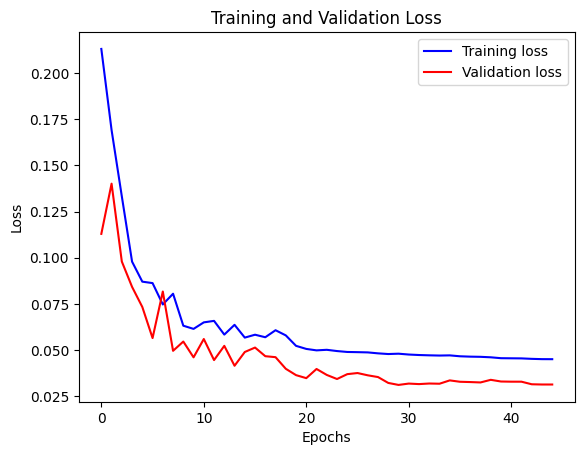

In [ ]:
epochs = 750
learning_rate = 0.0015

for batch in train_dataset.take(1):
    inputs, targets = batch
    
print("Inputs shape:", inputs.shape)
print("Targets shape:", targets.shape)
    
inputs = tf.keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))

lstm_out = tf.keras.layers.LSTM(225, return_sequences=True)(inputs)
lstm_out = tf.keras.layers.LSTM(75, return_sequences=False)(lstm_out)

#lstm_out = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_out)
#lstm_out = tf.keras.layers.LSTM(128)(lstm_out)


output_units = targets.shape[1] ### * targets.shape[2]  # Flatten output shape
outputs = tf.keras.layers.Dense(output_units)(lstm_out)
# Reshape to match the target shape
#outputs = tf.keras.layers.Reshape((targets.shape[1], targets.shape[2]))(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()


path_checkpoint = "model_checkpoint.weights.h5"
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=15)

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

# Added reduce on plateau
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    min_delta=0.00001,
    monitor='val_loss', 
    factor=0.5,         # reduce LR by a factor of 0.5
    patience=4,         # wait for 5 epochs before reducing
    verbose=1,
    min_lr=5e-7
)


history = model.fit(
    train_dataset,
    shuffle=False,
    epochs=epochs,
    validation_data=val_dataset,
    #callbacks=[es_callback, modelckpt_callback],
    callbacks=[es_callback, modelckpt_callback, reduce_lr_callback],
    #callbacks=[modelckpt_callback, reduce_lr_callback],
    
)

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")


['temperature']
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


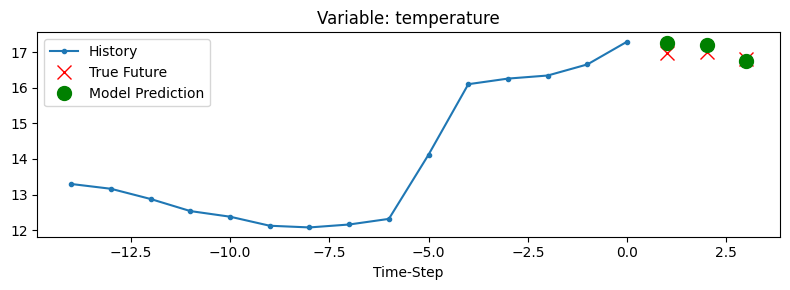

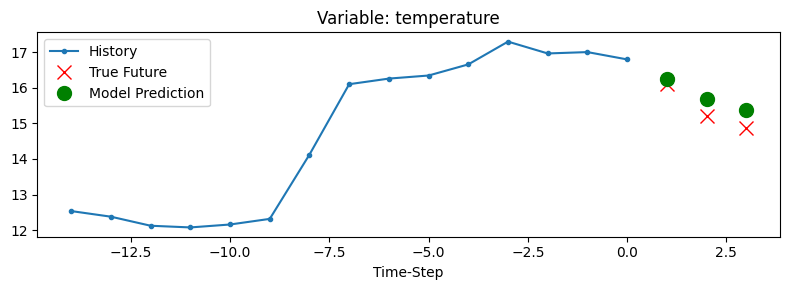

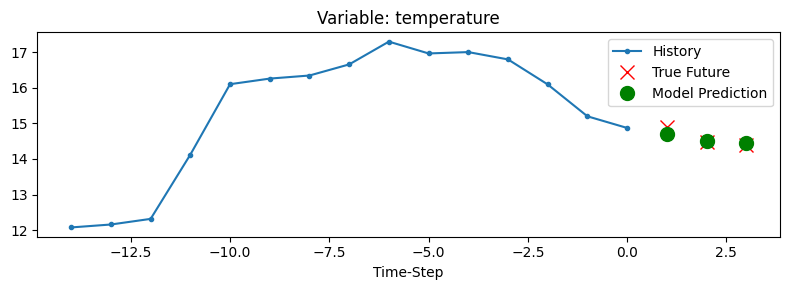

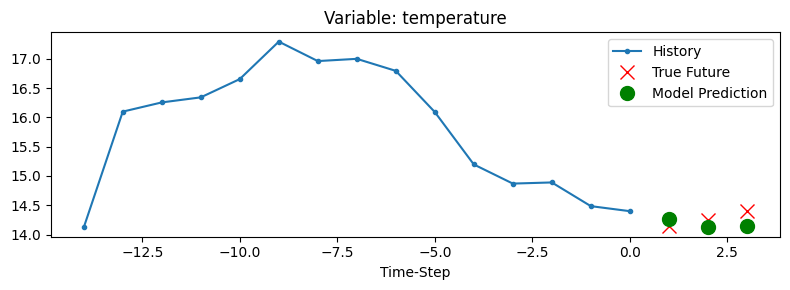

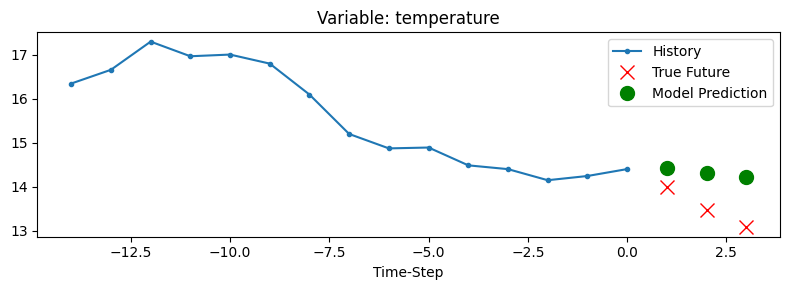

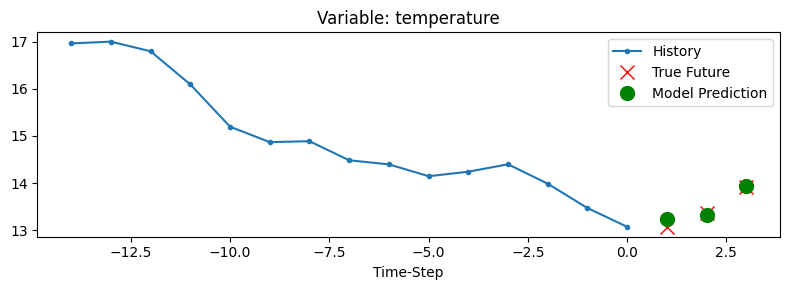

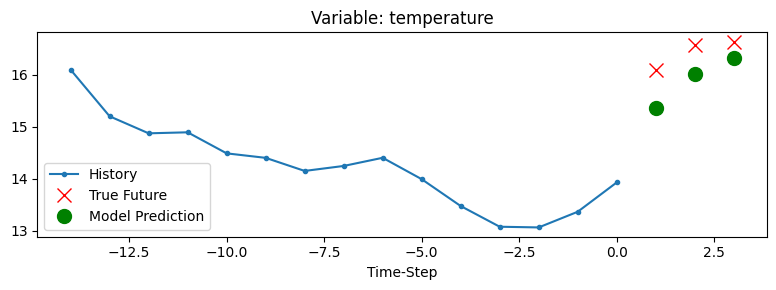

In [ ]:
def show_plots_for_variables(plot_data, delta, feature_names, mean, std):
    """
    Plots separate graphs for each variable, showing the 3 forecast points in true scale.
    
    Parameters:
    - plot_data: List containing [history, true future, model prediction].
    - delta: Time step offset for forecasts.
    - feature_names: List of feature names for labeling each subplot.
    - mean: Mean values for each feature (for denormalization).
    - std: Standard deviation values for each feature (for denormalization).
    """
    labels = ["History", "True Future", "Model Prediction"]
    markers = [".-", "rx", "go"]
    num_variables = 1  # Number of features

    fig, axes = plt.subplots(num_variables, 1, figsize=(8, num_variables * 3))

    if num_variables == 1:
        axes = [axes]  # Ensure axes is iterable for a single variable

    for i in range(num_variables):
        ax = axes[i]

        # Convert normalized values back to real scale
        history = plot_data[0][:, 4] * std[i] + mean[i]
        true_future = plot_data[1][:] * std[i] + mean[i]
        prediction = plot_data[2][:] * std[i] + mean[i]

        time_steps = list(range(-len(history)+ 1, 1))
        ax.plot(time_steps, history, markers[0], label=labels[0])

        # Plot forecasts
        forecast_time = list(range(delta + 1, delta + len(true_future) + 1))
        ax.plot(forecast_time, true_future, markers[1], markersize=10, label=labels[1])
        ax.plot(forecast_time, prediction, markers[2], markersize=10, label=labels[2])

        ax.set_title(f"Variable: {feature_names[i]}")
        ax.set_xlabel("Time-Step")
        ax.legend()
    
    plt.tight_layout()
    plt.show()


# Extract feature names (assuming dataset has feature names available)
feature_names = ["temperature"]  # Modify if real names exist
print(feature_names)

# Assuming `mean` and `std` are arrays with the same length as the number of features
for x, y in val_dataset.take(1):
    prediction = model.predict(x)
    for i in range(7):
        show_plots_for_variables([x[i][:, :].numpy(), y[i].numpy(), prediction[i]], 0, feature_names, mean, std)    
    

In [ ]:
mean = [ 20.345667, 977.2128,    68.56473 ]
std = [ 3.4997928,  3.3524375, 16.775301 ]

In [ ]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        # These are trainable layers that compute the attention score
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        # inputs shape: (batch_size, time_steps, hidden_units)
        # Compute score for each time step
        score = tf.nn.tanh(self.W(inputs))             # (batch_size, time_steps, units)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)  # (batch_size, time_steps, 1)
        # Multiply each hidden state by its attention weight and sum over time steps
        context_vector = tf.reduce_sum(attention_weights * inputs, axis=1)  # (batch_size, hidden_units)
        return context_vector